# Evaluating models on datasets

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm
import evaluate
import pandas as pd
import transformers
from evaluate import evaluator
from omegaconf import OmegaConf
from repsim.nlp import get_dataset, get_model
from bert_finetune import ShortcutAdder
import os


2024-04-04 08:44:10.931649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 08:44:11.717349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_dirs = [
    Path("/root/similaritybench/experiments/models/nlp/shortcut"),
]

model_pattern = "sst2*"
split = "validation"
shortcut_rates = [0, 0.25, 0.5, 0.75, 1.0]
device = 0

metric = evaluate.load("accuracy")
task_evaluator = evaluator("text-classification")

columns = ["model", "dataset", "sc_rate", "acc"]
records = []

csv_path = Path("shortcut_evals.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path, index_col=0)
else:
    df = pd.DataFrame(columns=columns)

for model_dir in model_dirs:
    for model_path in tqdm(model_dir.glob(model_pattern)):
        print(model_path)
        cfg = OmegaConf.load(model_path / "config.yaml")

        for shortcut_rate in shortcut_rates:
            if len(df.loc[(df["model"]==model_path.name) & (df["dataset"]==cfg.dataset.path) & (df["sc_rate"]==shortcut_rate)]) >0:
                print("result already exists, skipping")
                continue

            print(shortcut_rate)
            dataset = get_dataset(cfg.dataset.path, cfg.dataset.name)
            shortcutter = ShortcutAdder(
                num_labels=cfg.dataset.finetuning.num_labels,
                p=shortcut_rate,
                seed=cfg.shortcut_seed,
                feature_column=cfg.dataset.feature_column[0],
                label_column=cfg.dataset.target_column,
            )
            dataset = dataset.map(shortcutter)
            feature_column = shortcutter.new_feature_column
            tokenizer = transformers.AutoTokenizer.from_pretrained(
                cfg.model.kwargs.tokenizer_name,
                additional_special_tokens=shortcutter.new_tokens,
            )
            model = get_model(str(model_path))
            # print(model)
            model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=64)
            # print(model)
            model = model.to(f"cuda:{device}" if device != -1 else "cpu")
            pipe = transformers.pipeline(
                "text-classification",
                model=model,
                tokenizer=tokenizer,
                device=device,
                max_length=128,
            )

            results = task_evaluator.compute(
                model_or_pipeline=pipe,
                data=dataset[split],
                metric=metric,
                label_mapping={"LABEL_0": 0, "LABEL_1": 1},
                input_column=feature_column,
            )

            records.append((model_path.name, cfg.dataset.path, shortcut_rate, results["accuracy"]))
df = pd.DataFrame.from_records(records, columns=columns)


0it [00:00, ?it/s]

/root/similaritybench/experiments/models/nlp/shortcut/sst2_pre2_ft2_scrate0558
0
0.25
0.5
0.75
1.0
/root/similaritybench/experiments/models/nlp/shortcut/sst2_pre5_ft5_scrate0668
0


KeyboardInterrupt: 

In [ ]:

df.to_csv("shortcut_evals.csv")

## Analysis. Are models with different training setup distinguishable from their performance?

In [7]:
df = pd.read_csv("shortcut_evals.csv", index_col=0)

In [6]:
new_df = pd.read_csv("shortcut_evals_new.csv", index_col=0)

In [10]:
print(new_df.columns)
print(df.columns)

Index(['model', 'model_sc_rate', 'dataset', 'ds_sc_rate', 'acc'], dtype='object')
Index(['model', 'dataset', 'sc_rate', 'acc'], dtype='object')


In [12]:
df["ds_sc_rate"] = df["sc_rate"]

In [23]:
def scrate(s: str):
    str_to_float = {"0": 0.0, "025": 0.25, "05": 0.5, "075": 0.75,"10": 1.0,}
    s = s.split("_")[-1].replace("scrate", "")
    return str_to_float[s]

def seed(s: str):
    s = s.split("_")[1].replace("pre", "")
    return int(s)

split="validation"
clean_df = df.copy()
clean_df["split"] = split
clean_df["model_sc_rate"] = clean_df["model"].map(scrate)
clean_df["seed"] = clean_df["model"].map(seed)
clean_df


,model,dataset,sc_rate,acc,ds_sc_rate,split,model_sc_rate,seed
0,sst2_pre5_ft5_scrate05,sst2,0.00,0.915138,0.00,validation,0.5,5
1,sst2_pre5_ft5_scrate05,sst2,0.25,0.915138,0.25,validation,0.5,5
2,sst2_pre5_ft5_scrate05,sst2,0.50,0.915138,0.50,validation,0.5,5
3,sst2_pre5_ft5_scrate05,sst2,0.75,0.916284,0.75,validation,0.5,5
4,sst2_pre5_ft5_scrate05,sst2,1.00,0.916284,1.00,validation,0.5,5
...,...,...,...,...,...,...,...,...
245,sst2_pre8_ft8_scrate10,sst2,0.00,0.000000,0.00,validation,1.0,8
246,sst2_pre8_ft8_scrate10,sst2,0.25,0.237385,0.25,validation,1.0,8
247,sst2_pre8_ft8_scrate10,sst2,0.50,0.480505,0.50,validation,1.0,8
248,sst2_pre8_ft8_scrate10,sst2,0.75,0.729358,0.75,validation,1.0,8


In [24]:
clean_df = pd.concat((clean_df, new_df), axis=0).reset_index(drop=True)
clean_df

,model,dataset,sc_rate,acc,ds_sc_rate,split,model_sc_rate,seed
0,sst2_pre5_ft5_scrate05,sst2,0.00,0.915138,0.00,validation,0.5,5.0
1,sst2_pre5_ft5_scrate05,sst2,0.25,0.915138,0.25,validation,0.5,5.0
2,sst2_pre5_ft5_scrate05,sst2,0.50,0.915138,0.50,validation,0.5,5.0
3,sst2_pre5_ft5_scrate05,sst2,0.75,0.916284,0.75,validation,0.5,5.0
4,sst2_pre5_ft5_scrate05,sst2,1.00,0.916284,1.00,validation,0.5,5.0
...,...,...,...,...,...,...,...,...
295,sst2_pretrain8_finetune8,sst2,NaN,0.917431,0.00,NaN,0.0,NaN
296,sst2_pretrain5_finetune5,sst2,NaN,0.911697,0.00,NaN,0.0,NaN
297,sst2_pretrain6_finetune6,sst2,NaN,0.915138,0.00,NaN,0.0,NaN
298,sst2_pretrain9_finetune9,sst2,NaN,0.911697,0.00,NaN,0.0,NaN


In [33]:
clean_df.groupby(["model_sc_rate", "ds_sc_rate"])["acc"].agg(["mean", "std"]).xs(0.0, level=1, drop_level=False)

,,mean,std
model_sc_rate,ds_sc_rate,,
0.000,0.0,0.914048,0.008036
0.250,0.0,0.950573,0.004272
0.500,0.0,0.917202,0.006961
0.558,0.0,0.909060,0.006818
0.668,0.0,0.882683,0.005015
0.750,0.0,0.863303,0.018243
0.779,0.0,0.846904,0.014448
0.889,0.0,0.767775,0.035422
1.000,0.0,0.000000,0.000000


In [34]:
clean_df.loc[(clean_df.ds_sc_rate == 0) & (clean_df.model_sc_rate == 0.558)]

,model,dataset,sc_rate,acc,ds_sc_rate,split,model_sc_rate,seed
250,sst2_pre2_ft2_scrate0558,sst2,NaN,0.913991,0.0,NaN,0.558,NaN
252,sst2_pre6_ft6_scrate0558,sst2,NaN,0.913991,0.0,NaN,0.558,NaN
254,sst2_pre1_ft1_scrate0558,sst2,NaN,0.905963,0.0,NaN,0.558,NaN
256,sst2_pre5_ft5_scrate0558,sst2,NaN,0.904817,0.0,NaN,0.558,NaN
261,sst2_pre3_ft3_scrate0558,sst2,NaN,0.908257,0.0,NaN,0.558,NaN
265,sst2_pre9_ft9_scrate0558,sst2,NaN,0.893349,0.0,NaN,0.558,NaN
266,sst2_pre4_ft4_scrate0558,sst2,NaN,0.909404,0.0,NaN,0.558,NaN
269,sst2_pre0_ft0_scrate0558,sst2,NaN,0.909404,0.0,NaN,0.558,NaN
272,sst2_pre8_ft8_scrate0558,sst2,NaN,0.913991,0.0,NaN,0.558,NaN
281,sst2_pre7_ft7_scrate0558,sst2,NaN,0.917431,0.0,NaN,0.558,NaN


Index(['model', 'dataset', 'sc_rate', 'acc', 'ds_sc_rate', 'split',
       'model_sc_rate', 'seed'],
      dtype='object')


<Axes: xlabel='ds_sc_rate', ylabel='acc'>

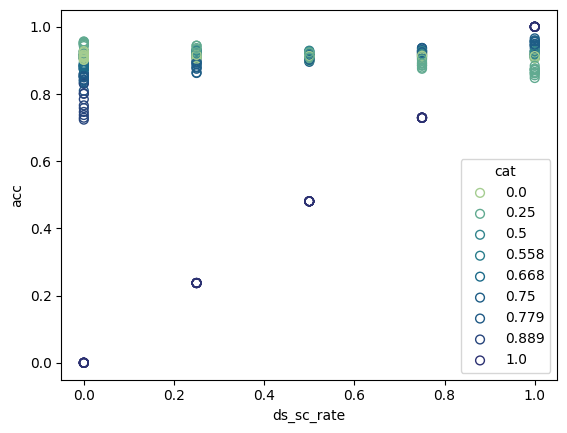

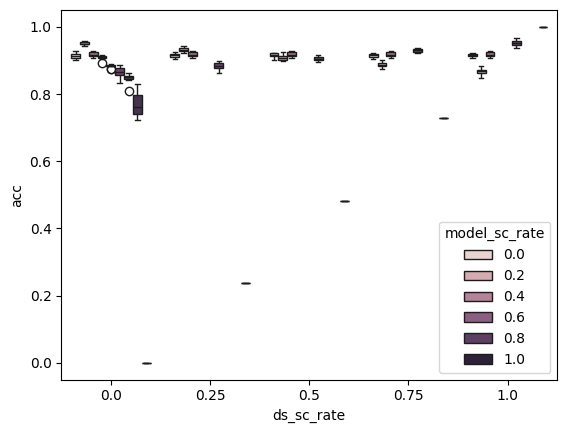

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

data = clean_df
print(data.columns)
plt.figure()
# sns.scatterplot(data=data, hue="model_sc_rate", y="acc", x="sc_rate", marker="o",fillstyle="None")
cmap = sns.color_palette("crest", as_cmap=True)
palette = {0.0: "C0", 0.25: "C1", 0.5: "C2", 0.75: "C3", 1.0: "C4"}
kws = {"s": 40, "facecolor": "none", "linewidth": 1}
ax = sns.scatterplot(
    data=data,
    x="ds_sc_rate",
    y="acc",
    edgecolor=data["model_sc_rate"].map(cmap),
    **kws,
)
handles, labels = zip(
    *[(plt.scatter([], [], ec=cmap(key), **kws), key) for key in sorted(data["model_sc_rate"].unique())]
)
ax.legend(handles, labels, title="cat")

plt.figure()
sns.boxplot(data=data, hue="model_sc_rate", y="acc", x="ds_sc_rate")

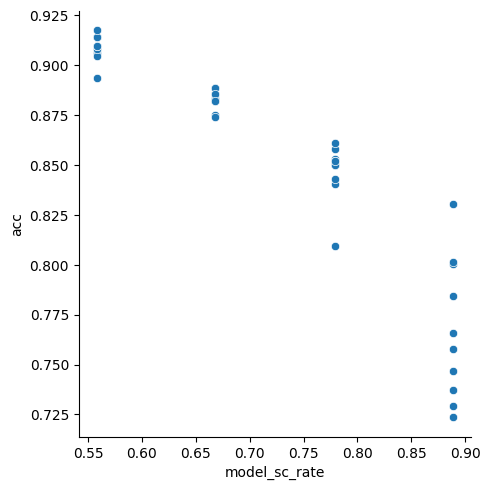

In [37]:
data = clean_df[clean_df.model_sc_rate.isin([0.558, 0.668, 0.779,0.889])]
sns.relplot(data=data, x="model_sc_rate", y="acc")

Statistically significant difference in avg acc?

In [ ]:
clean_df

In [27]:
import scipy.stats
import itertools

data = clean_df
selecting_feature = "model_sc_rate"
ds_selecting_feature = "ds_sc_rate"
cols = ["rate1", "rate2", "ds_rate", "acc1-mean", "acc2-mean", "pval"]
records = []
for aug1, aug2 in itertools.combinations(sorted(data[selecting_feature].unique()), r=2):
    for ds_strength in data[selecting_feature].unique():
        x = data.loc[(data[selecting_feature] == aug1) & (data[ds_selecting_feature] == ds_strength), "acc"]
        y = data.loc[(data[selecting_feature] == aug2) & (data[ds_selecting_feature] == ds_strength), "acc"]
        # print("aug1, aug2, ds", aug1, aug2, ds_strength)
        # print(len(x), len(y))
        # plt.figure()
        # sns.histplot(x)
        # sns.histplot(y)
        records.append(
            (aug1, aug2, ds_strength, x.mean(), y.mean(), scipy.stats.ttest_ind(x, y, permutations=10000).pvalue)
        )

pvals = pd.DataFrame.from_records(records, columns=cols)
pvals.head()

pvals[pvals.ds_rate == 0]

/root/similaritybench/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7597: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat_observed = _calc_t_stat(a, b, equal_var, axis=axis)
/root/similaritybench/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7530: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat.append(_calc_t_stat(a, b, equal_var))


,rate1,rate2,ds_rate,acc1-mean,acc2-mean,pval
1,0.000,0.250,0.0,0.914048,0.950573,0.000100
10,0.000,0.500,0.0,0.914048,0.917202,0.305469
19,0.000,0.558,0.0,0.914048,0.909060,0.104990
28,0.000,0.668,0.0,0.914048,0.882683,0.000100
37,0.000,0.750,0.0,0.914048,0.863303,0.000100
46,0.000,0.779,0.0,0.914048,0.846904,0.000100
55,0.000,0.889,0.0,0.914048,0.767775,0.000100
64,0.000,1.000,0.0,0.914048,0.000000,0.000100
73,0.250,0.500,0.0,0.950573,0.917202,0.000100
82,0.250,0.558,0.0,0.950573,0.909060,0.000100


In [28]:
significant = pvals[pvals.pval < 0.05]
print(len(significant)/len(pvals))

significant.sort_values(by=["rate1", "rate2", "ds_rate"])[significant.ds_rate == 0]

0.20987654320987653


/tmp/ipykernel_156180/1014551837.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  significant.sort_values(by=["rate1", "rate2", "ds_rate"])[significant.ds_rate == 0]


,rate1,rate2,ds_rate,acc1-mean,acc2-mean,pval
1,0.000,0.250,0.0,0.914048,0.950573,0.000100
28,0.000,0.668,0.0,0.914048,0.882683,0.000100
37,0.000,0.750,0.0,0.914048,0.863303,0.000100
46,0.000,0.779,0.0,0.914048,0.846904,0.000100
55,0.000,0.889,0.0,0.914048,0.767775,0.000100
64,0.000,1.000,0.0,0.914048,0.000000,0.000100
73,0.250,0.500,0.0,0.950573,0.917202,0.000100
82,0.250,0.558,0.0,0.950573,0.909060,0.000100
91,0.250,0.668,0.0,0.950573,0.882683,0.000100
100,0.250,0.750,0.0,0.950573,0.863303,0.000100
